In [1]:
import pandas as pd
import numpy as np

### Function

In [2]:
#==========================================================================================
#making time stamp uniform by Interpolation
from scipy import interpolate
def preprocess(data):
    freq=50
    ls=['X','Y','Z']
    t1=np.arange(data.Timestamp[0],data.Timestamp[(data.shape[0])-1],0.02)
    df=pd.DataFrame({'Timestamp':t1})
    for i in ls:
        fcubic = interpolate.interp1d(data.Timestamp, data[i], kind='cubic')
        df[i]=fcubic(t1)
    df.columns=['Timestamp','acc_X','acc_Y','acc_Z']
    return df

#==========================================================================================
#median filter
from scipy.signal import medfilt # import the median filter function
def median(signal):# input: numpy array 1D (one column)  
    #applying the median filter
    return  medfilt(np.array(signal), kernel_size=3) # applying the median filter order3(kernel_size=3)


#==========================================================================================
#components_selection_one_signal
import math # import math library


def components_selection_one_signal(t_signal):
    sampling_freq=50
    nyq=sampling_freq/float(2) # nyq is the nyquist frequency equal to the half of the sampling frequency[50/2= 25 Hz]

    freq1 = 0.3
    freq2 = 20

    t_signal=np.array(t_signal)
    t_signal_length=len(t_signal) # number of points in a t_signal
    
    # the t_signal in frequency domain after applying fft
    f_signal=np.fft.fft(t_signal) # 1D numpy array contains complex values (in C)
    
    # generate frequencies associated to f_signal complex values
    freqs=np.array(np.fft.fftfreq(t_signal_length, d=1/float(sampling_freq))) # frequency values between [-25hz:+25hz]
        
    df=pd.DataFrame({'freq':abs(freqs),'amplitute':f_signal})
    df['f_DC_signal']=np.where(df.freq>freq1,0,df.amplitute)
    #df['f_noise_signal']=np.where(df.freq<=freq2,0,df.amplitute)
    df['f_body_signal']=np.where(df.freq<=freq1,0,np.where(df.freq>freq2,0,df.amplitute))

    
    # Inverse the transformation of signals in freq domain #
    # applying the inverse fft(ifft) to signals in freq domain and put them in float format
    t_DC_component= np.fft.ifft(np.array(df['f_DC_signal'])).real
    t_body_component= np.fft.ifft(np.array(df['f_body_signal'])).real
    #t_noise=np.fft.ifft(np.array(df['f_noise_signal'])).real
    t_noise=[]
    
    #total_component=t_signal-t_noise # extracting the total component(filtered from noise) 
                                     #  by substracting noise from t_signal (the original signal).
    total_component=[]
    
    # return outputs mentioned earlier
    return (total_component,t_DC_component,t_body_component,t_noise) 


#=================================================================================================================
#Define verify gravity function
def mag_3_signals(df): # Euclidian magnitude
    return np.array(np.sqrt(np.square(df).sum(axis=1)))

def verify_gravity(data):
    
    acc_x=np.array(data['acc_X']) # copy acc_X column from dataframe in raw_dic having the key mentioned above
    acc_y=np.array(data['acc_Y'])# copy acc_Y column  from dataframe in raw_dic having the key mentioned above
    acc_z=np.array(data['acc_Z'])# copy acc_Z column  from dataframe in raw_dic having the key mentioned above

    # apply the filtering method to acc_[X,Y,Z] and store gravity components
    grav_acc_X=components_selection_one_signal(acc_x)[1] 
    grav_acc_Y=components_selection_one_signal(acc_y)[1]
    grav_acc_Z=components_selection_one_signal(acc_z)[1]
    
    # calculating gravity magnitude signal
    grav_acc_mag=mag_3_signals(grav_acc_X, grav_acc_Y,grav_acc_Z)
    print('mean value = ',round((sum(grav_acc_mag) / len(grav_acc_mag)),3),' g')
    
#=================================================================================================================    
#Define jerking and magnitude functions
def jerk_one_signal(signal):
    signal=pd.DataFrame(signal)
    jerk=(signal.shift(-1)-signal)/0.02
    return np.array(jerk.dropna()).transpose()[0]







In [3]:
#from scipy.signal import butter,filtfilt

### IDs_Labels Data

In [4]:
#Test Data
cis_pd_testing_id=pd.read_csv('test_data_Id/cis-pd.CIS-PD_Test_Data_IDs.csv')
real_pd_testing_id=pd.read_csv('test_data_Id/real-pd.REAL-PD_Test_Data_IDs.csv')

#Training Data
cis_pd_training_id=pd.read_csv('data_labels/CIS-PD_Training_Data_IDs_Labels.csv')
real_pd_training_id=pd.read_csv('data_labels/REAL-PD_Training_Data_IDs_Labels.csv')

#Ancillary Data
cis_pd_ancillary_id=pd.read_csv('data_labels/CIS-PD_Ancillary_Data_IDs_Labels.csv')
real_pd_ancillary_id=pd.read_csv('data_labels/REAL-PD_Ancillary_Data_IDs_Labels.csv')

### Cispd Data

In [5]:
import glob
a=glob.glob("training_data/*.csv")


In [6]:
data=preprocess(pd.read_csv(a[14]))

data.head()

,Timestamp,acc_X,acc_Y,acc_Z
0,0.00,0.186035,0.170654,-0.878174
1,0.02,0.148438,0.209961,-0.894287
2,0.04,0.166016,0.219727,-0.925049
3,0.06,0.206299,0.194092,-0.926758
4,0.08,0.173584,0.204102,-0.983154


In [8]:
from numpy.fft import fft

In [10]:
def time_domain_signal(data):
    time_sig_df=pd.DataFrame()
    for column in ['acc_X','acc_Y','acc_Z']:
        t_signal=np.array(data[column])
        #med_filtred=median(t_signal)
        med_filtred=(t_signal)
        _,grav_acc,body_acc,_=components_selection_one_signal(med_filtred)
        body_acc_jerk=jerk_one_signal(body_acc)
        time_sig_df['t_body_'+column]=body_acc[:-1]
        time_sig_df['t_grav_'+column]= grav_acc[:-1]
        time_sig_df['t_body_acc_jerk_'+column[-1]]=body_acc_jerk

    # all 15 axial signals generated above are reordered to facilitate magnitudes signals generation
    new_columns_ordered=['t_body_acc_X','t_body_acc_Y','t_body_acc_Z',
                              't_grav_acc_X','t_grav_acc_Y','t_grav_acc_Z',
                              't_body_acc_jerk_X','t_body_acc_jerk_Y','t_body_acc_jerk_Z']


    # create new dataframe to order columns
    time_sig_df=time_sig_df[new_columns_ordered]

    # Magnitude Features
    for i in range(0,9,3):
        mag_col_name=new_columns_ordered[i][:-1]+'mag'# Create the magnitude column name related to each 3-axial signals
        time_sig_df[mag_col_name]=mag_3_signals(time_sig_df[new_columns_ordered[i:i+3]]) # store the signal_mag with its appropriate column name

    return(time_sig_df)

In [11]:
time_sig_df=time_domain_signal(data)
time_sig_df.shape

(59999, 12)

In [12]:
time_sig_df.head()

,t_body_acc_X,t_body_acc_Y,t_body_acc_Z,t_grav_acc_X,t_grav_acc_Y,t_grav_acc_Z,t_body_acc_jerk_X,t_body_acc_jerk_Y,t_body_acc_jerk_Z,t_body_acc_mag,t_grav_acc_mag,t_body_acc_jerk_mag
0,0.051701,-0.309492,-0.430242,0.131715,0.558750,-0.319212,-1.716811,-4.916696,-12.082357,0.532510,0.656846,13.156925
1,0.017365,-0.407826,-0.671889,0.131556,0.549420,-0.335519,0.975826,6.859124,9.164233,0.786167,0.657071,11.488384
2,0.036881,-0.270644,-0.488604,0.131486,0.540100,-0.351798,1.638469,-4.648829,-5.982242,0.559770,0.657844,7.751349
3,0.069651,-0.363620,-0.608249,0.131505,0.530795,-0.368040,-1.029729,2.558821,1.223206,0.712066,0.659159,3.017307
4,0.049056,-0.312444,-0.583785,0.131613,0.521510,-0.384237,2.517675,1.077161,-0.436842,0.663952,0.661009,2.773048


In [13]:
#from scipy import fftpack # import fftpack to use all fft functions
from numpy.fft import *

# fast_fourier_transform_one_signal 
def fast_fourier_transform_one_signal(t_signal):
    return np.abs(np.fft.rfft(t_signal))

# fast fourier transform for data frames
def fast_fourier_transform(t_window):
    f_window=pd.DataFrame() 
    for column in t_window.columns: 
        if 'grav' not in column: # verify if time domain signal is not related to gravity components
            t_signal=np.array(t_window[column]) # convert the column to a 1D numpy array
            f_signal= fast_fourier_transform_one_signal(t_signal) # apply the function defined above to the column
            f_window["f_"+column[2:]]=f_signal # storing the frequency signal in f_window with an appropriate column name
    dfreq=np.array(np.fft.rfftfreq(len(t_signal), d=1/float(50))) 
    return f_window,dfreq # return the frequency domain window


In [14]:
freq_sig_df,dfreq=fast_fourier_transform(time_sig_df)

In [15]:
freq_sig_df.head()

,f_body_acc_X,f_body_acc_Y,f_body_acc_Z,f_body_acc_jerk_X,f_body_acc_jerk_Y,f_body_acc_jerk_Z,f_body_acc_mag,f_body_acc_jerk_mag
0,0.052618,0.284330,0.543517,0.045829,29.691091,48.687941,10776.777934,205803.224921
1,0.052618,0.284330,0.543518,0.045830,29.691094,48.687946,3784.454865,45070.684448
2,0.052619,0.284332,0.543522,0.045832,29.691103,48.687963,837.634454,16061.776519
3,0.052622,0.284335,0.543528,0.045835,29.691118,48.687991,1273.150911,26879.153451
4,0.052625,0.284339,0.543536,0.045839,29.691139,48.688031,376.690410,6166.657962


In [16]:
freq_sig_df.shape

(30000, 8)

### Common Axial Features Functions

In [17]:
# mean
def mean_axial(df):
    array=np.array(df) # convert dataframe into 2D numpy array for efficiency
    mean_vector = list(array.mean(axis=0)) # calculate the mean value of each column
    return mean_vector # return mean vetor
# std
def std_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    std_vector = list(array.std(axis=0))# calculate the standard deviation value of each column
    return std_vector

# mad
from statsmodels.robust import mad as median_deviation # import the median deviation function
def mad_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    mad_vector = list(median_deviation(array,axis=0)) # calculate the median deviation value of each column
    return mad_vector

# max

def max_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    max_vector=list(array.max(axis=0))# calculate the max value of each column
    return max_vector
# min
def min_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    min_vector=list(array.min(axis=0))# calculate the min value of each column
    return min_vector
# IQR
from scipy.stats import iqr as IQR # import interquartile range function (Q3(column)-Q1(column))
def IQR_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    IQR_vector=list(np.apply_along_axis(IQR,0,array))# calculate the inter quartile range value of each column
    return IQR_vector


# Entropy
from scipy.stats import entropy # import the entropy function
def entropy_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    entropy_vector=list(np.apply_along_axis(entropy,0,abs(array)))# calculate the entropy value of each column
    return entropy_vector

### Common Magnitude Features Functions

In [18]:
# mean
def mean_mag(mag_column):
    array=np.array(mag_column)
    mean_value = float(array.mean())
    return mean_value

# std: standard deviation of mag column
def std_mag(mag_column):
    array=np.array(mag_column)
    std_value = float(array.std()) # std value 
    return std_value

# mad: median deviation
def mad_mag(mag_column):
    array=np.array(mag_column)
    mad_value = float(median_deviation(array))# median deviation value of mag_column
    return mad_value

# max
def max_mag(mag_column):
    array=np.array(mag_column)
    max_value=float(array.max()) # max value 
    return max_value
# min
def min_mag(mag_column):
    array=np.array(mag_column)
    min_value= float(array.min()) # min value
    return min_value

# IQR
def IQR_mag(mag_column):
    array=np.array(mag_column)
    IQR_value=float(IQR(array))# Q3(column)-Q1(column)
    return IQR_value

# Entropy
def entropy_mag(mag_column):
    array=np.array(mag_column)
    entropy_value=float(entropy(array)) # entropy signal
    return entropy_value

### Time Axial Features functions

In [19]:
# sma
def t_sma_axial(df):
    array=np.array(df)
    sma_axial=float(abs(array).sum())/float(3) # sum of areas under each signal
    return sma_axial # return sma value

# energy
def t_energy_axial(df):
    array=np.array(df)
    energy_vector=list((array**2).sum(axis=0)) # energy value of each df column
    return energy_vector # return energy vector energy_X,energy_Y,energy_Z

# define the arbugr function
#auto regression coefficients with using burg method with order from 1 to 4
from spectrum import *

##############################################################################################
# I took this function as it is from this link ------>    https://github.com/faroit/freezefx/blob/master/fastburg.py
# This fucntion and the original function arburg in the library spectrum generate the same first 3 coefficients 
#for all windows the original burg method is low and for some windows it cannot generate all 4th coefficients 

def _arburg2(X, order):
    """This version is 10 times faster than arburg, but the output rho is not correct.
    returns [1 a0,a1, an-1]
    """
    x = numpy.array(X)
    N = len(x)

    if order == 0.:
        raise ValueError("order must be > 0")

    # Initialisation
    # ------ rho, den
    rho = sum(abs(x)**2.) / N  # Eq 8.21 [Marple]_
    den = rho * 2. * N

    # ------ backward and forward errors
    ef = numpy.zeros(N, dtype=complex)
    eb = numpy.zeros(N, dtype=complex)
    for j in range(0, N):  # eq 8.11
        ef[j] = x[j]
        eb[j] = x[j]

    # AR order to be stored
    a = numpy.zeros(1, dtype=complex)
    a[0] = 1
    # ---- rflection coeff to be stored
    ref = numpy.zeros(order, dtype=complex)

    E = numpy.zeros(order+1)
    E[0] = rho

    for m in range(0, order):
        # print m
        # Calculate the next order reflection (parcor) coefficient
        efp = ef[1:]
        ebp = eb[0:-1]
        # print efp, ebp
        num = -2. * numpy.dot(ebp.conj().transpose(), efp)
        den = numpy.dot(efp.conj().transpose(),  efp)
        den += numpy.dot(ebp,  ebp.conj().transpose())
        ref[m] = num / den

        # Update the forward and backward prediction errors
        ef = efp + ref[m] * ebp
        eb = ebp + ref[m].conj().transpose() * efp

        # Update the AR coeff.
        a.resize(len(a)+1)
        a = a + ref[m] * numpy.flipud(a).conjugate()

        # Update the prediction error
        E[m+1] = numpy.real((1 - ref[m].conj().transpose() * ref[m])) * E[m]
        # print 'REF', ref, num, den
    return a, E[-1], ref

#################################################################################################################

# to generate arburg (order 4) coefficents for 3 columns [X,Y,Z]
def t_arburg_axial(df):
    # converting signals to 1D numpy arrays for efficiency
    array_X=np.array(df[df.columns[0]])
    array_Y=np.array(df[df.columns[1]])
    array_Z=np.array(df[df.columns[2]])
    
    AR_X = list(_arburg2(array_X,4)[0][1:].real) # list contains real parts of all 4th coefficients generated from signal_X
    AR_Y = list(_arburg2(array_Y,4)[0][1:].real) # list contains real parts of all 4th coefficients generated from signal_Y
    AR_Z = list(_arburg2(array_Z,4)[0][1:].real) # list contains real parts of all 4th coefficients generated from signal_Z
    
    # selecting [AR1 AR2 AR3 AR4] real components for each axis concatenate them in one vector
    AR_vector= AR_X + AR_Y+ AR_Z
    
    
    # AR_vector contains 12 values 4values per each axis 
    return AR_vector


from scipy.stats import pearsonr
def t_corr_axial(df): # it returns 3 correlation features per each 3-axial signals in  time_window
    
    array=np.array(df)
    
    Corr_X_Y=float(pearsonr(array[:,0],array[:,1])[0]) # correlation value between signal_X and signal_Y
    Corr_X_Z=float(pearsonr(array[:,0],array[:,2])[0]) # correlation value between signal_X and signal_Z
    Corr_Y_Z=float(pearsonr(array[:,1],array[:,2])[0]) # correlation value between signal_Y and signal_Z
    
    corr_vector =[Corr_X_Y, Corr_X_Z, Corr_Y_Z] # put correlation values in list
    
    return corr_vector 
 
#hurst exponent
def hurst(signal):
    """
    **Experimental**/untested implementation taken from:
    http://drtomstarke.com/index.php/calculation-of-the-hurst-exponent-to-test-for-trend-and-mean-reversion/
    Use at your own risks.
    """
    
    signal=np.array(signal)
    tau = []; lagvec = []
    #  Step through the different lags
    for lag in range(2,20):
    #  produce price difference with lag
        pp = np.subtract(signal[lag:],signal[:-lag])
    #  Write the different lags into a vector
        lagvec.append(lag)
    #  Calculate the variance of the difference vector
        tau.append(np.std(pp))
    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lagvec),np.log10(tau),1)
    # calculate hurst
    hurst = m[0]
    return hurst


# to generate hurst  for 3 columns [X,Y,Z]
def t_hurst_axial(df):
    return list(df.apply(hurst,axis=0))


### Time Axial Features PipeLine

In [20]:
def t_axial_features_generation(t_window):
    
    # select axial columns : the first 9 columns
    axial_columns=t_window.columns[0:9]
    
    # select axial columns in a dataframe
    axial_df=t_window[axial_columns]
    
    ## a list will contain all axial features values resulted from applying: 
    #  common axial features functions and time axial features functions to all time domain signals in t_window
    t_axial_features=[]
    for col in range(0,9,3):
        df=axial_df[axial_columns[col:col+3]] # select each group of 3-axial signal: signal_name[X,Y,Z]
        
        # apply all common axial features functions and time axial features functions to each 3-axial signals dataframe
        mean_vector   = mean_axial(df) # 3values
        std_vector    = std_axial(df) # 3 values
        mad_vector    = mad_axial(df)# 3 values
        max_vector    = max_axial(df)# 3 values
        min_vector    = min_axial(df)# 3 values
        sma_value     = t_sma_axial(df)# 1 value
        energy_vector = t_energy_axial(df)# 3 values
        IQR_vector    = IQR_axial(df)# 3 values
        entropy_vector= entropy_axial(df)# 3 values
        AR_vector     = t_arburg_axial(df)# 3 values
        corr_vector   = t_corr_axial(df)# 3 values
        hurst_vector  = t_hurst_axial(df)# 3 values
        # 40 value per each 3-axial signals
        t_3axial_vector= mean_vector + std_vector + mad_vector + max_vector + min_vector + [sma_value] + energy_vector + IQR_vector + entropy_vector + AR_vector + corr_vector+hurst_vector
        
        # append these features to the global list of features
        t_axial_features= t_axial_features+ t_3axial_vector
    
    # t_axial_features contains 200 values = 40 value per each 3axial x 5 tri-axial-signals[X,Y,Z]
    return t_axial_features
    

In [21]:
len(t_axial_features_generation(time_sig_df))

129

### Define Time Magnitudes Features functions

In [22]:
# Functions used to generate time magnitude features

# sma: signal magnitude area
def t_sma_mag(mag_column):
    array=np.array(mag_column)
    sma_mag=float(abs(array).sum())# signal magnitude area of one mag column
    return sma_mag

# energy
def t_energy_mag(mag_column):
    array=np.array(mag_column)
    energy_value=float((array**2).sum()) # energy of the mag signal
    return energy_value



# arburg: auto regression coefficients using the burg method
def t_arburg_mag(mag_column):
    
    array = np.array(mag_column)
    
    AR_vector= list(_arburg2(array,4)[0][1:].real) # AR1, AR2, AR3, AR4 of the mag column
    #print(AR_vector)
    return AR_vector

In [23]:
hurst(time_sig_df.t_body_acc_X)

0.4194307331480186

### Time Magnitude Features PipLine

In [24]:
def t_mag_features_generation(t_window):
    
    # select mag columns : the last 3 columns in a time domain window
    
    mag_columns=t_window.columns[9:] # mag columns' names
    mag_columns=t_window[mag_columns] # mag data frame
    
    t_mag_features=[] # a global list will contain all time domain magnitude features
    
    for col in mag_columns: # iterate throw each mag column
        
        mean_value   = mean_mag(mag_columns[col]) # 1 value
        std_value    = std_mag(mag_columns[col])# 1 value
        mad_value    = mad_mag(mag_columns[col])# 1 value
        max_value    = max_mag(mag_columns[col])# 1 value
        min_value    = min_mag(mag_columns[col])# 1 value
        sma_value    = t_sma_mag(mag_columns[col])# 1 value
        energy_value = t_energy_mag(mag_columns[col])# 1 value
        IQR_value    = IQR_mag(mag_columns[col])# 1 value
        entropy_value= entropy_mag(mag_columns[col])# 1 value
        #hurst_vector    = hurst(mag_columns[col])# 1 value
        AR_vector    = t_arburg_mag(mag_columns[col])# 1 value
        
        # 13 value per each t_mag_column
        col_mag_values = [mean_value, std_value, mad_value, max_value, min_value, sma_value, 
                          energy_value,IQR_value, entropy_value]+ AR_vector
        
        # col_mag_values will be added to the global list
        t_mag_features= t_mag_features+ col_mag_values
    
    # t_mag_features contains 65 values = 13 values (per each t_mag_column) x 5 (t_mag_columns)
    return t_mag_features
 

In [25]:
len(t_mag_features_generation(time_sig_df))

39

In [26]:
len(t_axial_features_generation(time_sig_df))+len(t_mag_features_generation(time_sig_df))

168

### Time Features names Generation

In [27]:
def time_features_names():
    # Generating time feature names
    
    # time domain axial signals' names
    t_axis_signals=[['t_body_acc_X','t_body_acc_Y','t_body_acc_Z'],
                    ['t_grav_acc_X','t_grav_acc_Y','t_grav_acc_Z'],
                    ['t_body_acc_jerk_X','t_body_acc_jerk_Y','t_body_acc_jerk_Z']]
    
    # time domain magnitude signals' names
    magnitude_signals=['t_body_acc_Mag','t_grav_acc_Mag','t_body_acc_jerk_Mag']

    # functions' names:
    t_one_input_features_name1=['_mean()','_std()','_mad()','_max()','_min()']

    t_one_input_features_name2=['_energy()','_iqr()','_entropy()']

    t_one_input_features_name3=['_AR1()','_AR2()','_AR3()','_AR4()']

    correlation_columns=['_Corr(X,Y)','_Corr(X,Z)','_Corr(Y,Z)']

    t_one_input_features_name4=['_hurst()']
    

    features=[]# Empty list : it will contain all time domain features' names
    
    for columns in t_axis_signals: # iterate throw  each group of 3-axial signals'
        
        for feature in t_one_input_features_name1: # iterate throw the first list of functions names
            
            for column in columns: # iterate throw each axial signal in that group
                
                newcolumn=column[:-2]+feature+column[-2:] # build the feature name
                features.append(newcolumn) # add it to the global list
        
        sma_column=column[:-2]+'_sma()' # build the feature name sma related to that group
        features.append(sma_column) # add the feature to the list
        
        for feature in t_one_input_features_name2: # same process for the second list of features functions
            for column in columns:
                newcolumn=column[:-2]+feature+column[-2:]
                features.append(newcolumn)
        
        for column in columns:# same process for the third list of features functions
            for feature in t_one_input_features_name3:
                newcolumn=column[0:-2]+feature+column[-2:]
                features.append(newcolumn)
        
        for feature in correlation_columns: # adding correlations features
            newcolumn=column[0:-2]+feature
            features.append(newcolumn)
            
        for feature in t_one_input_features_name4: # adding correlations features
            for column in columns:
                newcolumn=column[:-2]+feature+column[-2:]
                features.append(newcolumn)
        

    for columns in magnitude_signals: # iterate throw time domain magnitude column names

        # build feature names related to that column
        #list 1
        for feature in t_one_input_features_name1:
            newcolumn=columns+feature
            features.append(newcolumn)
        # sma feature name
        sma_column=columns+'_sma()'
        features.append(sma_column)
        
        # list 2
        for feature in t_one_input_features_name2: 
            newcolumn=columns+feature
            features.append(newcolumn)
            
       
        # list 3
        for feature in t_one_input_features_name3:
            newcolumn=columns+feature
            features.append(newcolumn)
            
        
    ###########################################################################################################
    time_list_features=features
    
    return time_list_features # return all time domain features' names

In [28]:
len(time_features_names())

168

### Frequency Axial features functions

In [29]:
# sma
def f_sma_axial(df):
    array=np.array(df)
    sma_value=float((abs(array)/math.sqrt(array.shape[0])).sum())/float(3) # sma value of 3-axial f_signals
    return sma_value


# energy
def f_energy_axial(df):
    array=np.array(df)
    # spectral energy vector
    energy_vector=list((array**2).sum(axis=0)/float(len(array))) # energy of: f_signalX,f_signalY, f_signalZ
    return energy_vector # enrgy veactor=[energy(signal_X),energy(signal_Y),energy(signal_Z)]

#Max Inds and Mean_Freq Functions
# max_Inds
def f_max_Inds_axial(df,dfreq):
    array=np.array(df)
    max_Inds_X =dfreq[array[:,0].argmax()] # return the frequency related to max value of f_signal X
    max_Inds_Y =dfreq[array[:,1].argmax()] # return the frequency related to max value of f_signal Y
    max_Inds_Z =dfreq[array[:,2].argmax()] # return the frequency related to max value of f_signal Z
    max_Inds_vector= [max_Inds_X,max_Inds_Y,max_Inds_Z]# put those frequencies in a list
    return max_Inds_vector

# mean freq()
def f_mean_Freq_axial(df,dfreq):
    array=np.array(df)
    # sum of( freq_i * f_signal[i])/ sum of signal[i]
    mean_freq_X = np.dot(dfreq,array[:,0]).sum() / float(array[:,0].sum()) #  frequencies weighted sum using f_signalX
    mean_freq_Y = np.dot(dfreq,array[:,1]).sum() / float(array[:,1].sum()) #  frequencies weighted sum using f_signalY 
    mean_freq_Z = np.dot(dfreq,array[:,2]).sum() / float(array[:,2].sum()) #  frequencies weighted sum using f_signalZ
    mean_freq_vector=[mean_freq_X,mean_freq_Y,mean_freq_Z] # vector contain mean frequencies[X,Y,Z]
    return  mean_freq_vector


# Skewness & Kurtosis Functions
from scipy.stats import kurtosis       # kurtosis function
from scipy.stats import skew           # skewness function
    
def f_skewness_and_kurtosis_axial(df):
    array=np.array(df)
    skew_axial=list(skew(array,axis=0))
    kur_axial=list(kurtosis(array,axis=0))
    skew_kur_3axial_vector = [i for tup in zip(skew_axial,kur_axial) for i in tup]
    return  skew_kur_3axial_vector



#f_one_band_energy
def f_one_band_energy(psd, bands,dfreq):
    psd = np.abs(np.array(psd))**2
    bands = np.asarray(bands)
    freq_limits_low = np.concatenate([[1],bands])
    freq_limits_up = np.concatenate([bands, [25]])
    power_per_band_mean = [np.mean(psd[np.bitwise_and(dfreq >= low, dfreq<up)])
            for low,up in zip(freq_limits_low, freq_limits_up)]
    return power_per_band_mean

#spectral_entropy
def spectral_entropy(psd, bands,dfreq):
    psd = np.abs(np.array(psd))**2
    psd2 =psd/np.sum(psd) # psd as a pdf (normalised to one)
    bands = np.asarray(bands)
    freq_limits_low = np.concatenate([[1],bands])
    freq_limits_up = np.concatenate([bands, [25]])
    power_per_band = [np.sum(psd2[np.bitwise_and(dfreq >= low, dfreq<up)])
        for low,up in zip(freq_limits_low, freq_limits_up)]
    power_per_band=np.asarray(power_per_band)
    power_per_band= power_per_band[ power_per_band > 0]
    t=[- np.sum(power_per_band * np.log2(power_per_band))]
    return t

#Bands Energy FUNCTIONS
B1=[4,7,10,13,16,19,22] 
B2=[7,13,19]
B3=[12]


def f_all_bands_energy_axial(df,dfreq): # df is dataframe contain 3 columns (3-axial f_signals [X,Y,Z])
    E_3_axis =[]
    SE_3_axis =[]
    array=np.array(df)
    for i in range(0,3): # iterate throw signals
        E1=f_one_band_energy(array[:,i],B1,dfreq) # energy bands1 values of f_signal
        E2=f_one_band_energy(array[:,i],B2,dfreq)# energy bands2 values of f_signal
        E3=f_one_band_energy(array[:,i],B3,dfreq)# energy bands3 values of f_signal
        E_one_axis = E1+E2+E3 # list of energy bands values of one f_signal
        E_3_axis= E_3_axis + E_one_axis # add values to the global list
        
        SE1=spectral_entropy(array[:,i],B1,dfreq) # Senergy bands1 values of f_signal
        SE2=spectral_entropy(array[:,i],B2,dfreq)# Senergy bands2 values of f_signal
        SE3=spectral_entropy(array[:,i],B3,dfreq)# Senergy bands3 values of f_signal
        SE_one_axis = SE1+SE2+SE3 # list of energy bands values of one f_signal
        SE_3_axis= SE_3_axis + SE_one_axis # add values to the global list        
    return E_3_axis+SE_3_axis

### Frequency axial features PipeLine

In [30]:
def f_axial_features_generation(f_window,dfreq):
    
    
    axial_columns=f_window.columns[0:6] # select frequency axial column names
    axial_df=f_window[axial_columns] # select frequency axial signals in one dataframe
    f_all_axial_features=[] # a global list will contain all frequency axial features values
    
    
    
    for col in range(0,6,3):# iterate throw each group of frequency axial signals in a window
        
        df=axial_df[axial_columns[col:col+3]]  # select each group of 3-axial signals
      
        # mean
        mean_vector                  = mean_axial(df) # 3 values
        # std
        std_vector                   = std_axial(df) # 3 values
        # mad
        mad_vector                   = mad_axial(df) # 3 values
        # max
        max_vector                   = max_axial(df) # 3 values
        # min
        min_vector                   = min_axial(df) # 3 values
        # sma
        sma_value                    = f_sma_axial(df)
        # energy
        energy_vector                = f_energy_axial(df)# 3 values
        # IQR
        IQR_vector                   = IQR_axial(df) # 3 values
        # entropy
        entropy_vector               = entropy_axial(df) # 3 values
        # max_inds
        max_inds_vector              = f_max_Inds_axial(df,dfreq)# 3 values
        # mean_Freq
        mean_Freq_vector             = f_mean_Freq_axial(df,dfreq)# 3 values
        # skewness and kurtosis
        skewness_and_kurtosis_vector = f_skewness_and_kurtosis_axial(df)# 6 values
        # bands energy
        bands_energy_vector          = f_all_bands_energy_axial(df,dfreq) # 42 values

        # append all values of each 3-axial signals in a list
        f_3axial_features = mean_vector +std_vector + mad_vector + max_vector + min_vector + [sma_value] + energy_vector + IQR_vector + entropy_vector + max_inds_vector + mean_Freq_vector + skewness_and_kurtosis_vector + bands_energy_vector

        f_all_axial_features = f_all_axial_features+ f_3axial_features # add features to the global list
        
    return f_all_axial_features

In [31]:
len(f_axial_features_generation(freq_sig_df,dfreq))

176

### Define Frequency Magnitudes features functions

In [32]:
# Functions used to generate frequency magnitude features

# sma
def f_sma_mag(mag_column):
    
    array=np.array(mag_column)
    sma_value=float((abs(array)/math.sqrt(len(mag_column))).sum()) # sma of one mag f_signals
    
    return sma_value

# energy
def f_energy_mag(mag_column):
    
    array=np.array(mag_column)
    # spectral energy value
    energy_value=float((array**2).sum()/float(len(array))) # energy value of one mag f_signals
    return energy_value


####### Max Inds and Mean_Freq Functions#######################################


# max_Inds
def f_max_Inds_mag(mag_column,dfreq):
    
    array=np.array(mag_column)
    
    max_Inds_value =float(dfreq[array.argmax()]) # freq value related with max component
    
    return max_Inds_value

# mean freq()
def f_mean_Freq_mag(mag_column,dfreq):
    
    array=np.array(mag_column)
    
    mean_freq_value = float(np.dot(dfreq,array).sum() / float(array.sum())) # weighted sum of one mag f_signal
    
    return  mean_freq_value

###################################################################################

########## Skewness & Kurtosis Functions #######################################

from scipy.stats import skew           # skewness
def f_skewness_mag(mag_column):
    
    array=np.array(mag_column)
    skew_value     = float(skew(array)) # skewness value of one mag f_signal
    return skew_value



from scipy.stats import kurtosis       # kurtosis
def f_kurtosis_mag(mag_column):
    array=np.array(mag_column)
    kurtosis_value = float(kurtosis(array)) # kurotosis value of on mag f_signal

    return kurtosis_value
##################################################################################

### Define Frequency Magnitude features pipline

In [33]:
def f_mag_features_generation(f_window,dfreq):
    
    # select frequnecy mag columns : the last 2 columns in f_window
    mag_columns=f_window.columns[-2:]
    mag_columns=f_window[mag_columns]
    
    f_mag_features=[]
    for col in mag_columns: # iterate throw each mag column in f_window
        
        # calculate common mag features and frequency mag features for each column
        mean_value   = mean_mag(mag_columns[col])
        std_value    = std_mag(mag_columns[col])
        mad_value    = mad_mag(mag_columns[col])
        max_value    = max_mag(mag_columns[col])
        min_value    = min_mag(mag_columns[col])
        sma_value    = f_sma_mag(mag_columns[col])
        energy_value = f_energy_mag(mag_columns[col])
        IQR_value    = IQR_mag(mag_columns[col])
        entropy_value= entropy_mag(mag_columns[col])
        max_Inds_value=f_max_Inds_mag(mag_columns[col],dfreq)
        mean_Freq_value= f_mean_Freq_mag (mag_columns[col],dfreq)
        skewness_value=  f_skewness_mag(mag_columns[col])
        kurtosis_value = f_kurtosis_mag(mag_columns[col])
        # 13 value per each t_mag_column
        col_mag_values = [mean_value, std_value, mad_value, max_value, 
                          min_value, sma_value, energy_value,IQR_value, 
                          entropy_value, max_Inds_value, mean_Freq_value,
                          skewness_value, kurtosis_value ]
        
        
        f_mag_features= f_mag_features+ col_mag_values # append feature values of one mag column to the global list
    
    # f_mag_features contains 65 values = 13 value (per each t_mag_column) x 4 (f_mag_columns)
    return f_mag_features
    

In [34]:
len(f_mag_features_generation(freq_sig_df,dfreq))

26

In [35]:
len(f_mag_features_generation(freq_sig_df,dfreq))+len(f_axial_features_generation(freq_sig_df,dfreq))

202

### Frequency features name generation

In [36]:
def frequency_features_names():
    #Generating Frequency feature names
    
    # frequency axial signal names 
    axial_signals=[
                    ['f_body_acc_X','f_body_acc_Y','f_body_acc_Z'],
                    ['f_body_acc_Jerk_X','f_body_acc_Jerk_Y','f_body_acc_Jerk_Z']]

    # frequency magnitude signals
    mag_signals=['f_body_acc_Mag','f_body_acc_Jerk_Mag']


    # features functions names will be applied to f_signals
    f_one_input_features_name1=['_mean()','_std()','_mad()','_max()','_min()']

    f_one_input_features_name2=['_energy()','_iqr()','_entropy()','_maxInd()','_meanFreq()']

    f_one_input_features_name3= ['_skewness()','_kurtosis()']


    f_one_input_features_name4=[
                                '_BE[1-4]','_BE[4-7]','_BE[7-10]','_BE[10-13]',
                                '_BE[13-16]','_BE[16-19]','_BE[19-22]','_BE[22-25]',
                                '_BE[1-7]','_BE[7-13]','_BE[13-19]','_BE[19-25]',
                                '_BE[1-12]','_BE[12-25]','_SE_B1','_SE_B2','_SE_B3'
                               ]
    
    frequency_features_names=[] # global list of frequency features
    
    for columns in axial_signals: # iterate throw each group of 3-axial signals
        
        # iterate throw the first list of features
        for feature in f_one_input_features_name1: 
            for column in columns:# iterate throw each signal name of that group
                newcolumn=column[:-2]+feature+column[-2:] # build the full feature name
                frequency_features_names.append(newcolumn) # add the feature name to the global list
        
        # sma feature name
        sma_column=column[:-2]+'_sma()'
        frequency_features_names.append(sma_column)

        # iterate throw the first list of features
        for feature in f_one_input_features_name2:
            for column in columns:
                newcolumn=column[:-2]+feature+column[-2:]
                frequency_features_names.append(newcolumn)
        
        # iterate throw each signal name of that group
        for column in columns:
            for feature in f_one_input_features_name3: # iterate throw [skewness ,kurtosis]
                newcolumn=column[:-2]+feature+column[-2:] # build full feature name
                frequency_features_names.append(newcolumn) # append full feature names
        
        # same process above will be applied to list number 4
        for column in columns:
            for feature in f_one_input_features_name4:
                newcolumn=column[:-2]+feature+column[-2:]
                frequency_features_names.append(newcolumn)
   
    #################################################################################################################
    # generate frequency mag features names
    for column in mag_signals:# iterate throw each frequency mag signal name
        for feature in f_one_input_features_name1:# iterate throw the first list of features functions names
            frequency_features_names.append(column+feature) # build the full feature name and add it to the global list

        sma_column=column+'_sma()' # build the sma full feature name
        frequency_features_names.append(sma_column) # add it to the global list

        for feature in f_one_input_features_name2:# iterate throw the second list of features functions names
            frequency_features_names.append(column+feature)# build the full feature name and add it to the global list
        
        for feature in f_one_input_features_name3:# iterate throw the third list of features functions names
            frequency_features_names.append(column+feature)# build the full feature name and add it to the global list
    ####################################################################################################################
    
    return frequency_features_names

In [37]:
len(frequency_features_names())

202

### Define Addtional features functions

In [38]:
############### Angles Functions ####################################
from math import acos # inverse of cosinus function
from math import sqrt # square root function

########Euclidian magnitude 3D############
def magnitude_vector(vector3D): # vector[X,Y,Z]
    return sqrt((vector3D**2).sum()) # eulidian norm of that vector

###########angle between two vectors in radian ###############
def angle(vector1, vector2):
    vector1_mag=magnitude_vector(vector1) # euclidian norm of V1
    vector2_mag=magnitude_vector(vector2) # euclidian norm of V2
   
    scalar_product=np.dot(vector1,vector2) # scalar product of vector 1 and Vector 2
    cos_angle=scalar_product/float(vector1_mag*vector2_mag) # the cosinus value of the angle between V1 and V2
    
    # just in case some values were added automatically
    if cos_angle>1:
        cos_angle=1
    elif cos_angle<-1:
        cos_angle=-1
    
    angle_value=float(acos(cos_angle)) # the angle value in radian
    return angle_value # in radian.

################## angle_features ############################
def angle_features(t_window): # it returns 7 angles per window
    angles_list=[]# global list of angles values
    
    # mean value of each column t_body_acc[X,Y,Z]
    V2_columns=['t_grav_acc_X','t_grav_acc_Y','t_grav_acc_Z']
    V2_Vector=np.array(t_window[V2_columns].mean()) # mean values
    
    # angle 0: angle between (t_body_acc[X.mean,Y.mean,Z.mean], t_gravity[X.mean,Y.mean,Z.mean])
    V1_columns=['t_body_acc_X','t_body_acc_Y','t_body_acc_Z']
    V1_Vector=np.array(t_window[V1_columns].mean()) # mean values of t_body_acc[X,Y,Z]
    angles_list.append(angle(V1_Vector, V2_Vector)) # angle between the vectors added to the global list
    
    # same process is applied to ither signals
    # angle 1: (t_body_acc_jerk[X.mean,Y.mean,Z.mean],t_gravity[X.mean,Y.mean,Z.mean]
    V1_columns=['t_body_acc_jerk_X','t_body_acc_jerk_Y','t_body_acc_jerk_Z']
    V1_Vector=np.array(t_window[V1_columns].mean())
    angles_list.append(angle(V1_Vector, V2_Vector))
    
    #################################################################################
    
    # V1 vector in this case is the X axis itself [1,0,0]
    # angle 4: ([X_axis],t_gravity[X.mean,Y.mean,Z.mean])   
    V1_Vector=np.array([1,0,0])
    angles_list.append(angle(V1_Vector, V2_Vector))
    
    # V1 vector in this case is the Y axis itself [0,1,0]
    # angle 5: ([Y_acc_axis],t_gravity[X.mean,Y.mean,Z.mean]) 
    V1_Vector=np.array([0,1,0])
    angles_list.append(angle(V1_Vector, V2_Vector))
    
    # V1 vector in this case is the Z axis itself [0,0,1]
    # angle 6: ([Z_acc_axis],t_gravity[X.mean,Y.mean,Z.mean])
    V1_Vector=np.array([0,0,1])
    angles_list.append(angle(V1_Vector, V2_Vector))
    
    return angles_list


In [39]:
angle_features(time_sig_df)

[1.8582164377002448,
 1.3007985123846297,
 0.7741285023936461,
 0.8086298496777289,
 1.68035254598756]

### Define Additional features names

In [40]:
angle_columns=['angle0()','angle1()','angle2()','angle3()','angle4()']

In [41]:
len(angle_columns)

5

### Define Datasets generation PipeLine

In [42]:
# conctenate all features names lists and we add two other columns activity ids and user ids will be related to each row
all_columns=time_features_names()+frequency_features_names()+angle_columns

def Dataset_Generation_PipeLine(b):
    data=preprocess(pd.read_csv(b))
    time_sig_df=time_domain_signal(data)
    freq_sig_df,dfreq=fast_fourier_transform(time_sig_df)

    # conctenate all features names lists and we add two other columns activity ids and user ids will be related to each row
    all_columns=time_features_names()+frequency_features_names()+angle_columns
    # generate all time features from t_window 
    time_features = t_axial_features_generation(time_sig_df) + t_mag_features_generation(time_sig_df)
    # generate all frequency features from f_window
    frequency_features = f_axial_features_generation(freq_sig_df,dfreq) + f_mag_features_generation(freq_sig_df,dfreq)

    # Generate addtional features from t_window
    additional_features= angle_features(time_sig_df)

    # concatenate all features and append the activity id and the user id
    row= time_features + frequency_features + additional_features 
    return(row)



In [43]:
len(all_columns)

375

In [44]:
from joblib import Parallel, delayed
import multiprocessing

### training data

In [45]:
import time
start_time = time.time()
num_cores = multiprocessing.cpu_count()
result=Parallel(n_jobs=num_cores)(delayed(Dataset_Generation_PipeLine)(i) for i in a)
print("--- %s Mins ---" % ((time.time() - start_time)/60))
#6.510 min with median filter

--- 6.510010866324107 Mins ---


In [46]:
df_train=pd.DataFrame(result)
df_train.columns=all_columns
df_train.head()

,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_acc_Jerk_Mag_entropy(),f_body_acc_Jerk_Mag_maxInd(),f_body_acc_Jerk_Mag_meanFreq(),f_body_acc_Jerk_Mag_skewness(),f_body_acc_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4()
0,-3.334246e-06,3.380387e-06,1.393120e-06,0.099944,0.142005,0.108190,0.033039,0.043726,0.047271,1.112432,...,9.915110,0.0,10.021254,94.912617,12878.953973,1.269448,1.899860,1.065528,0.518106,1.465910
1,-4.346947e-06,3.036928e-06,6.113366e-06,0.066548,0.083700,0.079469,0.024560,0.030279,0.031635,1.354605,...,9.901163,0.0,9.000563,60.912551,6957.106067,1.413412,1.801430,1.376456,0.239518,1.709022
2,-1.549262e-06,-3.047034e-06,-4.311244e-06,0.037920,0.048990,0.042020,0.021843,0.026923,0.024576,0.730232,...,9.893109,0.0,9.273361,90.922463,12118.515289,2.341412,0.729455,1.812981,0.420034,1.234689
3,6.043703e-06,3.538011e-07,-8.543812e-06,0.126068,0.124452,0.135372,0.055065,0.065481,0.073943,1.131224,...,9.903191,0.0,8.904894,99.631375,13949.566962,1.180943,1.914003,1.431382,2.699205,1.987684
4,-5.536921e-07,-9.914527e-07,-8.850714e-07,0.037933,0.037771,0.037048,0.005124,0.005134,0.006956,0.835984,...,9.899734,0.0,9.354405,65.151538,6715.891110,1.925886,1.154342,1.643372,0.427678,1.991465


In [47]:
df_train['measurement_id']=[item[len('training_data/'):-4] for item in a]
df_train.shape

(1858, 376)

In [48]:
# ancillary_data
b=glob.glob("ancillary_data/*.csv")
import time
start_time = time.time()
num_cores = multiprocessing.cpu_count()
result=Parallel(n_jobs=num_cores)(delayed(Dataset_Generation_PipeLine)(i) for i in b)
print("--- %s Mins ---" % ((time.time() - start_time)/60))
#1.788 min

In [49]:
df_ancillary=pd.DataFrame(result)
df_ancillary.columns=all_columns
df_ancillary['measurement_id']=[item[len('ancillary_data/'):-4] for item in b]
df_ancillary.head()

--- 1.6091588656107585 Mins ---


In [50]:
df_train = df_train.append(pd.DataFrame(data = df_ancillary), ignore_index=True)
df_train.shape

,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,...,f_body_acc_Jerk_Mag_entropy(),f_body_acc_Jerk_Mag_maxInd(),f_body_acc_Jerk_Mag_meanFreq(),f_body_acc_Jerk_Mag_skewness(),f_body_acc_Jerk_Mag_kurtosis(),angle0(),angle1(),angle2(),angle3(),angle4()
0,-4.132057e-06,-4.619516e-07,3.014532e-06,0.098321,0.113157,0.109394,0.061607,0.078441,0.083154,1.467124,...,9.928507,0.0,9.546565,113.737713,16932.330711,1.977980,1.471455,1.389324,0.342242,1.857654
1,2.112434e-07,1.333250e-06,3.491435e-06,0.052415,0.068039,0.075028,0.020012,0.027996,0.038551,0.615687,...,9.948590,0.0,9.794009,105.250800,15132.571561,1.477625,1.633479,1.607294,0.271720,1.839930
2,7.866500e-07,7.516715e-06,1.960748e-06,0.072958,0.075990,0.067542,0.009487,0.008411,0.005033,1.738231,...,9.920737,0.0,9.174132,50.365359,4294.556588,1.432036,1.714774,1.316599,1.210568,2.693780
3,-2.946285e-06,7.022481e-07,-9.067563e-07,0.065199,0.069987,0.092864,0.022233,0.019657,0.028050,1.316846,...,9.925683,0.0,9.532988,79.022477,9682.320464,1.470014,1.647442,1.326512,0.574352,2.078858
4,-1.951282e-07,3.865437e-06,3.459577e-06,0.036045,0.042543,0.047066,0.010846,0.011335,0.010262,0.825205,...,9.953125,0.0,9.993389,46.536089,4763.459664,1.357752,1.692959,1.501817,0.627668,2.193459


In [57]:
pd.set_option('display.max_columns', 500)
df_train.head()

,t_body_acc_mean()_X,t_body_acc_mean()_Y,t_body_acc_mean()_Z,t_body_acc_std()_X,t_body_acc_std()_Y,t_body_acc_std()_Z,t_body_acc_mad()_X,t_body_acc_mad()_Y,t_body_acc_mad()_Z,t_body_acc_max()_X,t_body_acc_max()_Y,t_body_acc_max()_Z,t_body_acc_min()_X,t_body_acc_min()_Y,t_body_acc_min()_Z,t_body_acc_sma(),t_body_acc_energy()_X,t_body_acc_energy()_Y,t_body_acc_energy()_Z,t_body_acc_iqr()_X,t_body_acc_iqr()_Y,t_body_acc_iqr()_Z,t_body_acc_entropy()_X,t_body_acc_entropy()_Y,t_body_acc_entropy()_Z,t_body_acc_AR1()_X,t_body_acc_AR2()_X,t_body_acc_AR3()_X,t_body_acc_AR4()_X,t_body_acc_AR1()_Y,t_body_acc_AR2()_Y,t_body_acc_AR3()_Y,t_body_acc_AR4()_Y,t_body_acc_AR1()_Z,t_body_acc_AR2()_Z,t_body_acc_AR3()_Z,t_body_acc_AR4()_Z,"t_body_acc_Corr(X,Y)","t_body_acc_Corr(X,Z)","t_body_acc_Corr(Y,Z)",t_body_acc_hurst()_X,t_body_acc_hurst()_Y,t_body_acc_hurst()_Z,t_grav_acc_mean()_X,t_grav_acc_mean()_Y,t_grav_acc_mean()_Z,t_grav_acc_std()_X,t_grav_acc_std()_Y,t_grav_acc_std()_Z,t_grav_acc_mad()_X,t_grav_acc_mad()_Y,t_grav_acc_mad()_Z,t_grav_acc_max()_X,t_grav_acc_max()_Y,t_grav_acc_max()_Z,t_grav_acc_min()_X,t_grav_acc_min()_Y,t_grav_acc_min()_Z,t_grav_acc_sma(),t_grav_acc_energy()_X,t_grav_acc_energy()_Y,t_grav_acc_energy()_Z,t_grav_acc_iqr()_X,t_grav_acc_iqr()_Y,t_grav_acc_iqr()_Z,t_grav_acc_entropy()_X,t_grav_acc_entropy()_Y,t_grav_acc_entropy()_Z,t_grav_acc_AR1()_X,t_grav_acc_AR2()_X,t_grav_acc_AR3()_X,t_grav_acc_AR4()_X,t_grav_acc_AR1()_Y,t_grav_acc_AR2()_Y,t_grav_acc_AR3()_Y,t_grav_acc_AR4()_Y,t_grav_acc_AR1()_Z,t_grav_acc_AR2()_Z,t_grav_acc_AR3()_Z,t_grav_acc_AR4()_Z,"t_grav_acc_Corr(X,Y)","t_grav_acc_Corr(X,Z)","t_grav_acc_Corr(Y,Z)",t_grav_acc_hurst()_X,t_grav_acc_hurst()_Y,t_grav_acc_hurst()_Z,t_body_acc_jerk_mean()_X,t_body_acc_jerk_mean()_Y,t_body_acc_jerk_mean()_Z,t_body_acc_jerk_std()_X,t_body_acc_jerk_std()_Y,t_body_acc_jerk_std()_Z,t_body_acc_jerk_mad()_X,t_body_acc_jerk_mad()_Y,t_body_acc_jerk_mad()_Z,t_body_acc_jerk_max()_X,t_body_acc_jerk_max()_Y,t_body_acc_jerk_max()_Z,t_body_acc_jerk_min()_X,t_body_acc_jerk_min()_Y,t_body_acc_jerk_min()_Z,t_body_acc_jerk_sma(),t_body_acc_jerk_energy()_X,t_body_acc_jerk_energy()_Y,t_body_acc_jerk_energy()_Z,t_body_acc_jerk_iqr()_X,t_body_acc_jerk_iqr()_Y,t_body_acc_jerk_iqr()_Z,t_body_acc_jerk_entropy()_X,t_body_acc_jerk_entropy()_Y,t_body_acc_jerk_entropy()_Z,t_body_acc_jerk_AR1()_X,t_body_acc_jerk_AR2()_X,t_body_acc_jerk_AR3()_X,t_body_acc_jerk_AR4()_X,t_body_acc_jerk_AR1()_Y,t_body_acc_jerk_AR2()_Y,t_body_acc_jerk_AR3()_Y,t_body_acc_jerk_AR4()_Y,t_body_acc_jerk_AR1()_Z,t_body_acc_jerk_AR2()_Z,t_body_acc_jerk_AR3()_Z,t_body_acc_jerk_AR4()_Z,"t_body_acc_jerk_Corr(X,Y)","t_body_acc_jerk_Corr(X,Z)","t_body_acc_jerk_Corr(Y,Z)",t_body_acc_jerk_hurst()_X,t_body_acc_jerk_hurst()_Y,t_body_acc_jerk_hurst()_Z,t_body_acc_Mag_mean(),t_body_acc_Mag_std(),t_body_acc_Mag_mad(),t_body_acc_Mag_max(),t_body_acc_Mag_min(),t_body_acc_Mag_sma(),t_body_acc_Mag_energy(),t_body_acc_Mag_iqr(),t_body_acc_Mag_entropy(),t_body_acc_Mag_AR1(),t_body_acc_Mag_AR2(),t_body_acc_Mag_AR3(),t_body_acc_Mag_AR4(),t_grav_acc_Mag_mean(),t_grav_acc_Mag_std(),t_grav_acc_Mag_mad(),t_grav_acc_Mag_max(),t_grav_acc_Mag_min(),t_grav_acc_Mag_sma(),t_grav_acc_Mag_energy(),t_grav_acc_Mag_iqr(),t_grav_acc_Mag_entropy(),t_grav_acc_Mag_AR1(),t_grav_acc_Mag_AR2(),t_grav_acc_Mag_AR3(),t_grav_acc_Mag_AR4(),t_body_acc_jerk_Mag_mean(),t_body_acc_jerk_Mag_std(),t_body_acc_jerk_Mag_mad(),t_body_acc_jerk_Mag_max(),t_body_acc_jerk_Mag_min(),t_body_acc_jerk_Mag_sma(),t_body_acc_jerk_Mag_energy(),t_body_acc_jerk_Mag_iqr(),t_body_acc_jerk_Mag_entropy(),t_body_acc_jerk_Mag_AR1(),t_body_acc_jerk_Mag_AR2(),t_body_acc_jerk_Mag_AR3(),t_body_acc_jerk_Mag_AR4(),f_body_acc_mean()_X,f_body_acc_mean()_Y,f_body_acc_mean()_Z,f_body_acc_std()_X,f_body_acc_std()_Y,f_body_acc_std()_Z,f_body_acc_mad()_X,f_body_acc_mad()_Y,f_body_acc_mad()_Z,f_body_acc_max()_X,f_body_acc_max()_Y,f_body_acc_max()_Z,f_body_acc_min()_X,f_body_acc_min()_Y,f_body_acc_min()_Z,f_body_acc_sma(),

In [59]:
df_train.shape

(2210, 376)

In [62]:
df_train.to_csv('analysis2_cispd_comp_training_abhiroop_tillhurst.csv',index=False)

### test data

In [55]:
# Test Data
a=glob.glob("testing_data/*.csv")
start_time = time.time()
num_cores = multiprocessing.cpu_count()
result=Parallel(n_jobs=num_cores)(delayed(Dataset_Generation_PipeLine)(i) for i in a)

df_test=pd.DataFrame(result)
df_test.columns=all_columns
df_test['measurement_id']=[item[len('testing_data/'):-4] for item in a]
df_test.shape

(618, 376)

In [65]:
df_test.to_csv('analysis2_cispd_comp_testing_abhiroop_tillhurst.csv',index=False)

### label

In [67]:
cis_pd_id=cis_pd_training_id.append(pd.DataFrame(data=cis_pd_ancillary_id),ignore_index=True)
df_train=pd.merge(cis_pd_id,df_train,on='measurement_id')

In [68]:
df_train.shape

(2210, 380)

# Modeling

In [69]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from catboost import CatBoostRegressor, FeaturesData, Pool
from sklearn.metrics import mean_squared_error

/Users/akuma824/Desktop/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## LightGBM

In [70]:
def lightgbm(df4,label):
    train=df4[~df4[label].isnull()]

    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=1)

    d_train = lgb.Dataset(x_train, label=y_train)

    params = {}
    params['learning_rate'] = 0.03
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression'
    params['metric'] = 'rmse'
    params['max_depth'] = 5
    params['feature_fraction'] = 0.8
    clf = lgb.train(params, d_train, 150)
    y_pred=clf.predict(x_test)
    y_pred2=clf.predict(x_train)

    #print('lightgbm train_MSE '+label+' :',round(mean_squared_error(y_train, y_pred2),3))
    print('lightgbm test_MSE '+label+' :',round(mean_squared_error(y_test, y_pred),3))

## Catboost

In [71]:
#This will give indexes of the categorical features
def categorical_index(df,cols):
    cat=[]
    for c in cols:
        try:
            cat.append(df.columns.get_loc(c))
        except:
            pass # doing nothing on exception
    return cat

def catboost(df4,label):    
    train=df4[~df4[label].isnull()]
    X_train, X_test, y_train, y_test = train_test_split(train.drop(['measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=1)
    train_dataset = Pool(data=X_train,
                         label=y_train,
                         cat_features=categorical_index(X_train,['subject_id','Gender']))

    eval_dataset = Pool(data=X_test,
                        label=y_test,
                        cat_features=categorical_index(X_train,['subject_id','Gender']))



    model = CatBoostRegressor(iterations=50, learning_rate=0.1, depth=6,verbose=False)
    # Fit model
    model.fit(train_dataset)
    # Get predictions
    preds = model.predict(eval_dataset)
    preds2 = model.predict(train_dataset)

    #print('catboost train_MSE '+label+' :',round(mean_squared_error(y_train, preds2),3))
    print('catboost test_MSE '+label+' :',round(mean_squared_error(y_test, preds),3))

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def get_lgbm_varimp(df4,label, max_vars=50):
    train=df4[~df4[label].isnull()]

    # Splitting the dataset into the Training set and Test set
    x_train, x_test, y_train, y_test = train_test_split(train.drop(['measurement_id','on_off','dyskinesia','tremor'], axis = 1), train[label], 
                                                        train_size=0.7, 
                                                        stratify = train[label],
                                                        random_state=1)

    d_train = lgb.Dataset(x_train, label=y_train)

    params = {}
    params['learning_rate'] = 0.03
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'regression'
    params['metric'] = 'rmse'
    params['max_depth'] = 5
    params['feature_fraction'] = 0.8
    clf = lgb.train(params, d_train, 150)
    
    X=x_train
    model=clf
    num=max_vars
    
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=(40, 40))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

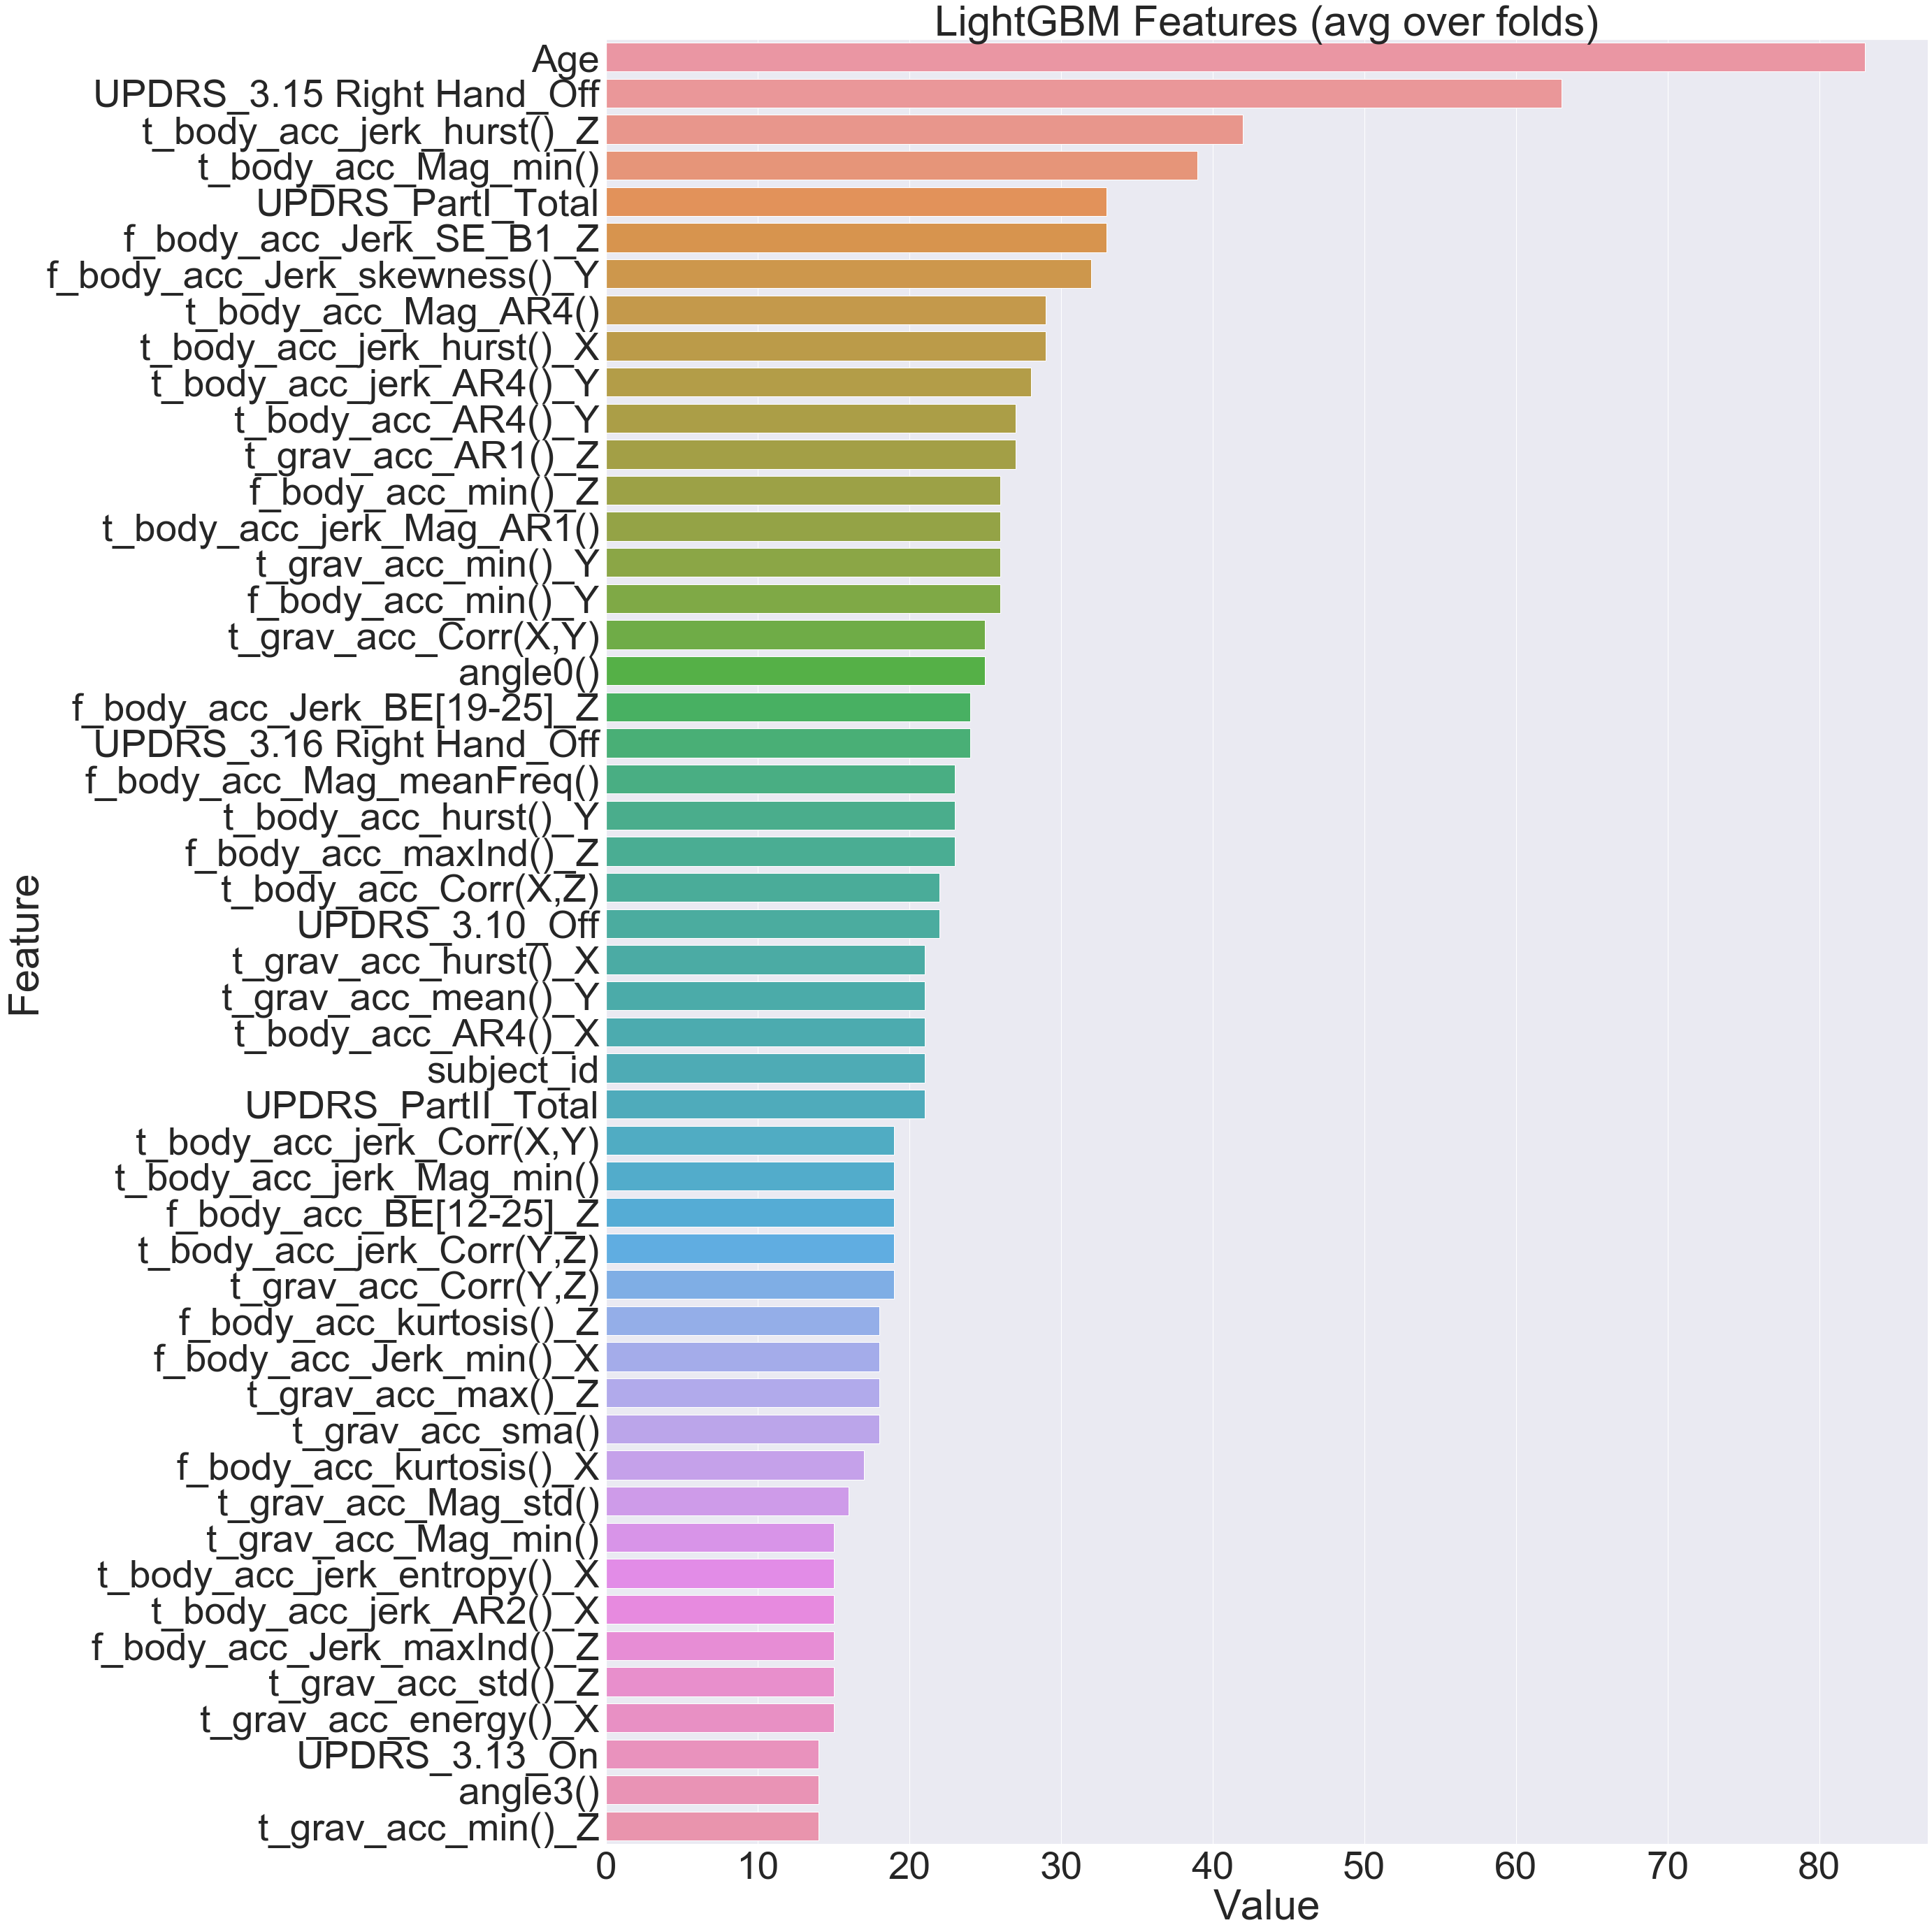

In [484]:
get_lgbm_varimp(df_train2,'tremor')

In [74]:
lightgbm(df_train,'tremor')
catboost(df_train,'tremor')

lightgbm(df_train,'dyskinesia')
catboost(df_train,'dyskinesia')

lightgbm(df_train,'on_off')
catboost(df_train,'on_off')

lightgbm test_MSE tremor : 0.346
catboost test_MSE tremor : 0.357
lightgbm test_MSE dyskinesia : 0.381
catboost test_MSE dyskinesia : 0.341
lightgbm test_MSE on_off : 1.167
catboost test_MSE on_off : 1.079


In [ ]:
lightgbm test_MSE tremor : 0.321
catboost test_MSE tremor : 0.326
lightgbm test_MSE dyskinesia : 0.366
catboost test_MSE dyskinesia : 0.348
lightgbm test_MSE on_off : 1.091
catboost test_MSE on_off : 1.101